Session 2: Template analysis and categories
===============================================

## Part 1: Template analysis

Sometimes we do not have a parametric form to describe our fit but rather rely on simulated events.

The likelihood takes the form of: $$\mathcal{L}=\prod_i \mathcal{P}(x_\text{obs}|x_\text{exp})$$

or equivalently (using the multinomial distribution):
$$ \mathcal{L} = \mathcal{P}(N_\text{obs}| N_\text{exp}) \mathcal{M}(x_\text{obs}|p_\text{exp})$$

We start with a simple fit where we have a signal shape(h_sig), a background shape h_bkg, and the data distribution, h_data.

### Vertical morphing
Nuisances can be incorporated as usual:
$$\mathcal{L}=\mathcal{L}_\text{stat}\,\mathcal{N}(\vec{\theta},\vec{\theta}_\text{in})$$

where $\mathcal{N}$ is the joint p.d.f. for the nuisance parameters $\vec{\theta}$

Usually, we will talk about vertical morphing between two histograms if at each point $x$ we can have that the p.d.f. for the expectations $x_\text{exp}$ can be expressed as $f(x_\text{exp})$.

### Horizontal morphing

Peaky structures can be interpolated with different techniques (horizontal morphing, momentum morphings ...) in order to obtain different points. 
The horizonthal morphing of two histograms ($h_1(x), h_2(x)$ ) consist in:

$$ H^{-1}(y,\theta) = (\theta H_1^{-1}(y) + (1-\theta)H_2^{-1}(y))$$

where $H_{1/2}(x)$ is the c.d.f. of $h_{1/2}(x)$


## Part 2: Categories: Simultaneous pdfs

We can include as many channel as we want by making the product of the likelihood functions.

$$ \mathcal{L}=\prod_i \mathcal{L}_i$$

being the channel $i$ template-based, parametric or unbinned.



In [1]:
# import ROOT libraries. and something else
import ROOT
import os,sys,re
import numpy as np

Welcome to JupyROOT 6.17/01


In [2]:
## rS+B histogram: fit for r Constructing the shapes. 

#### PREPARING THE INPUTS ###
fOut=ROOT.TFile.Open("input.root","RECREATE")
ROOT.gRandom.SetSeed(123456)
ROOT.RooRandom.randomGenerator().SetSeed(654321)
x=ROOT.RooRealVar("x","x",1.,0,10)
x.setBins(20)
t=ROOT.RooRealVar("tau","tau",-0.5)
## s,b

pdf_true = [ROOT.RooUniform("b","b",ROOT.RooArgSet(x)),ROOT.RooExponential("s","s",x,t)]
n_true = [10000.,100.]
## do pseudo observation
f=ROOT.RooRealVar("f","f",n_true[0]/(n_true[0]+n_true[1]*1.2))
pdf_true.append(ROOT.RooAddPdf("data_true","data_true",ROOT.RooArgList(pdf_true[0],pdf_true[1]), ROOT.RooArgList(f) ) )
n_true.append(n_true[0]+n_true[1]*1.2) ##sig_region

pdf_true.append(pdf_true[0])
n_true.append(n_true[0]*5) #bkg region

enhance= [100.,100.,1.,1.] ## how much MC do I have?

n_obs  = [ROOT.gRandom.Poisson(n*e) for n,e in zip(n_true,enhance)]
ds_obs = [pdf.generate(ROOT.RooArgSet(x),n) for pdf,n in zip(pdf_true,n_obs)]


name=["h_bkg","h_sig","h_data","h_data2"]
#hist= [ds.createHistogram("x",10) for n,ds in zip(name,ds_obs)] ## overload fail. 
hist = [ ROOT.RooAbsData.createHistogram( ds, n, x) for n,ds in zip(name,ds_obs)]
[h.Scale(1./e) for h,e in zip(hist,enhance)]

#write
fOut.cd()
[h.Write() for h in hist]
fOut.Close()



RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



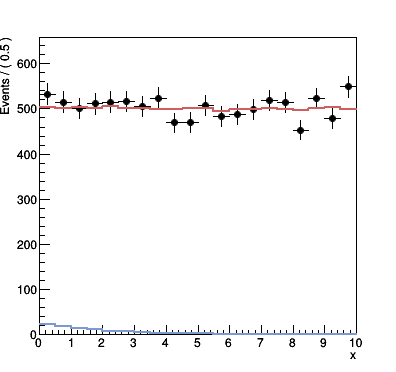

In [3]:
## Read the inputs and plot the histograms
fIn=ROOT.TFile.Open("input.root")

#fIn.ls()
h_data=fIn.Get("h_data__x")
h_sig=fIn.Get("h_sig__x")
h_bkg=fIn.Get("h_bkg__x")

h_bkg.SetLineColor(46)
h_sig.SetLineColor(38)
h_bkg.SetLineWidth(2)
h_sig.SetLineWidth(2)
h_data.SetLineColor(ROOT.kBlack)
h_data.SetMarkerColor(ROOT.kBlack)
h_data.SetMarkerStyle(20)
h_data.SetMarkerSize(0.8)

c=ROOT.TCanvas("c","c",400,400)
h_data.Draw("PE")
h_data.GetYaxis().SetRangeUser(0,h_data.GetMaximum()*1.2)
h_sig.Draw("HIST SAME")
h_bkg.Draw("HIST SAME")

ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)

c.Draw()

In [4]:
# create the binned dataset to fit
x=ROOT.RooRealVar("x","x",1,0,10)
hist=[h_data,h_sig,h_bkg]
name=["data","sig","bkg"]
dh=[ROOT.RooDataHist("dh_%s"%n,"%s distribution"%n,ROOT.RooArgList(x),h) for n,h in zip(name,hist)]
## s and b pdf 
pdf=[ROOT.RooHistPdf("hp_%s"%n, "%s",ROOT.RooArgSet(x), d) for n,d in zip(name[1:],dh[1:])]

rv_sig,rv_bkg=ROOT.RooRealVar("ns","ns",h_sig.Integral(),0,5*h_sig.Integral()),ROOT.RooRealVar("nb","nb",h_bkg.Integral(),0,2*h_bkg.Integral())
model_s=ROOT.RooAddPdf("model_s","model_s",ROOT.RooArgList(pdf[0],pdf[1]), ROOT.RooArgList(rv_sig,rv_bkg) ) 


#fr=model_s.fitTo(dh[0],ROOT.RooFit.Extended())

nll=model_s.createNLL(dh[0],ROOT.RooFit.Extended())
minuit=ROOT.RooMinuit(nll)
minuit.migrad()
minuit.improve()
minuit.hesse()
minuit.minos()

print "Fitted number of events: S=",rv_sig.getVal(),"B=",rv_bkg.getVal(),"TOT=",rv_sig.getVal()+rv_bkg.getVal()
print "strength=",rv_sig.getVal()/h_sig.Integral(), "TOT data=",h_data.Integral()

Fitted number of events: S= 105.002825471 B= 9966.97779835 TOT= 10071.9806238
strength= 1.05160565197 TOT data= 10072.0
 **********
 **   13 **MIGRAD        1000           1
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT, WITH IFLAG=4.
 START MIGRAD MINIMIZATION.  STRATEGY  1.  CONVERGENCE WHEN EDM .LT. 1.00e-03
 FCN=-59576.5 FROM MIGRAD    STATUS=INITIATE        8 CALLS           9 TOTAL
                     EDM= unknown      STRATEGY= 1      NO ERROR MATRIX       
  EXT PARAMETER               CURRENT GUESS       STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  nb           1.00060e+04   2.00119e+03   2.01358e-01   3.35487e+01
   2  ns           9.98500e+01   4.99250e+01   2.57889e-01   5.10203e-01
                               ERR DEF= 0.5
 MIGRAD MINIMIZATION HAS CONVERGED.
 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.
 COVARIANCE MATRIX CALCULATED SUCCESSFULLY
 FCN=-59576.5 FROM MIGRAD    STATUS=CONVERGED      33

[#1] INFO:Minization -- RooProfileLL::evaluate(nll_model_s_dh_data_Profile[ns]) Creating instance of MINUIT
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_model_s_dh_data_Profile[ns]) determining minimum likelihood for current configurations w.r.t all observable
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_model_s_dh_data_Profile[ns]) minimum found at (ns=105.092)
..................................................................................

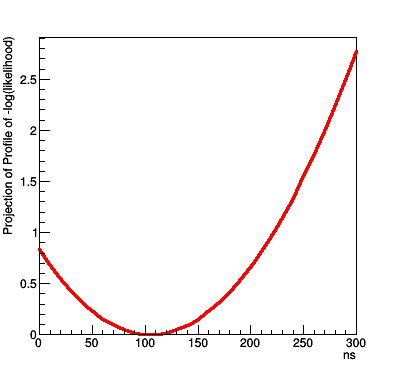

In [5]:
frame = rv_sig.frame(ROOT.RooFit.Bins(20), ROOT.RooFit.Range(0,300))

#Plot the profile likelihood in nsig
pll_frac = nll.createProfile(ROOT.RooArgSet(rv_sig))
pll_frac.plotOn(frame, ROOT.RooFit.LineColor(ROOT.kRed))

c=ROOT.TCanvas("c_pl","c_pl",400,400)
frame.Draw()
c.Draw()


[#1] INFO:Plotting -- RooAbsPdf::plotOn(model_s) directly selected PDF components: (hp_bkg)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model_s) indirectly selected PDF components: ()


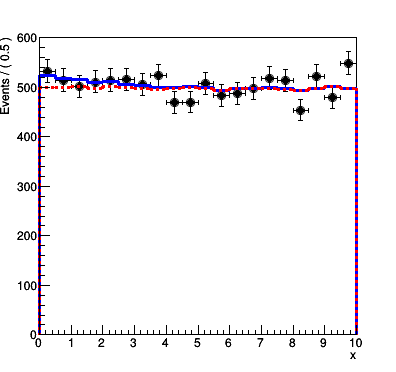

In [6]:
# plot fit
frame = x.frame() 
dh[0].plotOn(frame)
model_s.plotOn(frame) 
model_s.plotOn(frame, ROOT.RooFit.Components("hp_bkg"),
               ROOT.RooFit.LineStyle(ROOT.kDashed),
               ROOT.RooFit.LineColor(ROOT.kRed)
              ) 
c=ROOT.TCanvas("c_fit","c_fit",400,400)
frame.Draw() ;
c.Draw()

## Simultaneous Fit
the bkg region has 5 times the expected yields for the bkg in the sig region. 
Correlate the two categories with this transfer factor.


In [7]:
## construct a Simultaneous pdf

# take the other data histogram
hdata2=fIn.Get("h_data2__x")

#reminder of definitions
#hist=[h_data,h_sig,h_bkg,h_data2]
#name=["data","sig","bkg","data2"]

dh_data2=ROOT.RooDataHist("dh_data2","data2 distribution",ROOT.RooArgList(x),hdata2) 

# construct a model that uses data2 in the second category 
#and correlates the pdf and bkg yields among the two catgeories

rfv_bkg2=ROOT.RooFormulaVar("nbkg2","@0*5",ROOT.RooArgList(rv_bkg))
model2=ROOT.RooExtendPdf("model2","model2",pdf[1],rfv_bkg2)

# construct the model
cat = ROOT.RooCategory("cat", "cat")
cat.defineType("SR")
cat.defineType("CR")

combData = ROOT.RooDataHist("combData2","combData2", ROOT.RooArgList(x),
                            ROOT.RooFit.Index(cat),
                            ROOT.RooFit.Import("SR",dh[0]),
                            ROOT.RooFit.Import("CR",dh_data2)
                           )
                            
# Construct the simultaneous model
simPdf=ROOT.RooSimultaneous("simPdf","simultaneous pdf",cat) ;

simPdf.addPdf(model_s,"SR") 
simPdf.addPdf(model2,"CR") 

fr=simPdf.fitTo(combData,ROOT.RooFit.Offset(True),
                ROOT.RooFit.Minimizer("Minuit2","migradimproved")
               ) # or construct nll


print rv_sig.getVal()+rv_bkg.getVal()+rfv_bkg2.getVal(), "==",combData.sumEntries(),dh[0].sumEntries(),dh_data2.sumEntries()

59897.9858806 == 59898.0 10072.0 49826.0
[#1] INFO:Minization -- p.d.f. provides expected number of events, including extended term in likelihood.
RooAbsTestStatistic::initSimMode: creating slave calculator #0 for state SR (100 dataset entries)
RooAbsTestStatistic::initSimMode: creating slave calculator #1 for state CR (100 dataset entries)
[#1] INFO:Fitting -- RooAbsTestStatistic::initSimMode: created 2 slave calculators.
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:Minization --  The following expressions have been identified as constant and will be precalculated and cached: (hp_sig,hp_bkg)
[#1] INFO:Minization --  The following expressions have been identified as constant and will be precalculated and cached: (hp_bkg)
 **********
 **  748 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 nb           9.96698e+03  1.28623e+02    0.00000e+00  2.00119e+04
     2 ns           1.

Warning in <ROOT::Math::FitConfig::CreateMinimizer>: Could not create the Minuit2 minimizer. Try using the minimizer Minuit
Warning in <ROOT::Math::FitConfig::CreateMinimizer>: Could not create the Minuit2 minimizer. Try using the minimizer Minuit


[#1] INFO:Plotting -- RooAbsPdf::plotOn(model_s) directly selected PDF components: (hp_bkg)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model_s) indirectly selected PDF components: ()


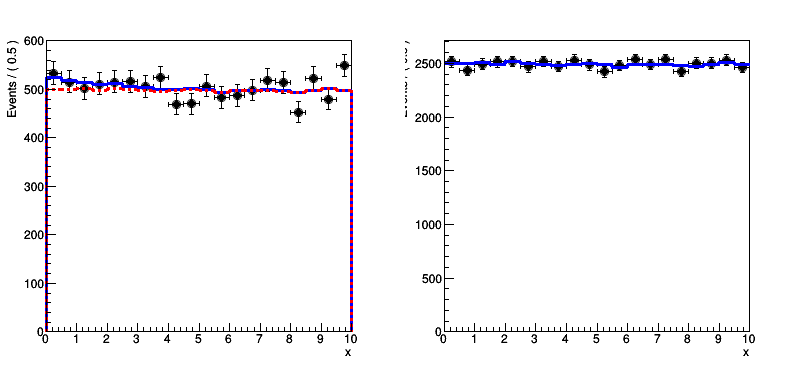

In [8]:
## Plot slices

frame1 = x.frame(ROOT.RooFit.Bins(20),ROOT.RooFit.Title("Signal Region")) ;

dh[0].plotOn(frame1)
model_s.plotOn(frame1,ROOT.RooFit.Normalization(rv_sig.getVal()+rv_bkg.getVal(),ROOT.RooAbsReal.NumEvent) )
model_s.plotOn(frame1, ROOT.RooFit.Normalization(rv_sig.getVal()+rv_bkg.getVal(),ROOT.RooAbsReal.NumEvent),
               ROOT.RooFit.Components("hp_bkg"),
               ROOT.RooFit.LineStyle(ROOT.kDashed),
               ROOT.RooFit.LineColor(ROOT.kRed)
              ) 


frame2 = x.frame(ROOT.RooFit.Bins(20),ROOT.RooFit.Title("Control Region")) ;

dh_data2.plotOn(frame2)
model2.plotOn(frame2,ROOT.RooFit.Normalization(rfv_bkg2.getVal(),ROOT.RooAbsReal.NumEvent))
 
c=ROOT.TCanvas("c_sim","c_sim",800,400)

c.Divide(2) 
c.cd(1) 
frame1.Draw() 
c.cd(2) ;
frame2.Draw()
c.Draw()

In [9]:
## or with nll
nll2=model2.createNLL(dh_data2,ROOT.RooFit.Minimizer("minuit2","migradimproved"))

#nllsim=ROOT.RooAddition("nllsim","nllsim",ROOT.RooArgList(nll2,nll)) ;
nllsim=simPdf.createNLL(combData,ROOT.RooFit.NumCPU(8))

minuit2=ROOT.RooMinuit(nllsim)
minuit2.migrad()
minuit2.improve()
minuit2.hesse()

0

[#0] ERROR:InputArguments -- RooAbsPdf::createNLL(model2) ERROR: unrecognized command: Minimizer
[#1] INFO:Minization -- p.d.f. provides expected number of events, including extended term in likelihood.
[#1] INFO:Minization -- p.d.f. provides expected number of events, including extended term in likelihood.
 **********
 **   13 **MIGRAD        1000           1
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT, WITH IFLAG=4.
RooAbsTestStatistic::initSimMode: creating slave calculator #0 for state SR (100 dataset entries)
RooAbsTestStatistic::initSimMode: creating slave calculator #1 for state CR (100 dataset entries)
[#1] INFO:Fitting -- RooAbsTestStatistic::initSimMode: created 2 slave calculators.
[#1] INFO:Eval -- RooAbsTestStatistic::initMPMode: started 8 remote server process.
 START MIGRAD MINIMIZATION.  STRATEGY  1.  CONVERGENCE WHEN EDM .LT. 1.00e-03
 FCN=-392436 FROM MIGRAD    STATUS=INITIATE        4 CALLS           5 TOTAL
                     EDM= unknown      STRA

[#1] INFO:Minization -- RooProfileLL::evaluate(nll_model_s_dh_data_Profile[ns]) Creating instance of MINUIT
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_model_s_dh_data_Profile[ns]) determining minimum likelihood for current configurations w.r.t all observable
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_model_s_dh_data_Profile[ns]) minimum found at (ns=105.389)
..................................................................................
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_simPdf_combData2_Profile[ns]) Creating instance of MINUIT
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_simPdf_combData2_Profile[ns]) determining minimum likelihood for current configurations w.r.t all observable
RooAbsTestStatistic::initSimMode: creating slave calculator #0 for state SR (100 dataset entries)
RooAbsTestStatistic::initSimMode: creating slave calculator #1 for state CR (100 dataset entries)
[#1] INFO:Fitting -- RooAbsTestStatistic::initSimMode: created 2 slave calc

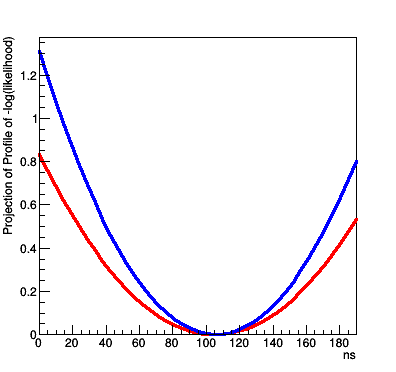

In [10]:
frame = rv_sig.frame(ROOT.RooFit.Bins(20), ROOT.RooFit.Range(0,190))

#Plot the profile likelihood in nsig
pll_frac.plotOn(frame, ROOT.RooFit.LineColor(ROOT.kRed))

pll2 = nllsim.createProfile(ROOT.RooArgSet(rv_sig) )
pll2.plotOn(frame, ROOT.RooFit.LineColor(ROOT.kBlue))

c=ROOT.TCanvas("c_pl","c_pl",400,400)
frame.Draw()
c.Draw()


[#1] INFO:Minization -- RooProfileLL::evaluate(nll_model_s_dh_data_Profile[nb]) Creating instance of MINUIT
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_model_s_dh_data_Profile[nb]) determining minimum likelihood for current configurations w.r.t all observable
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_model_s_dh_data_Profile[nb]) minimum found at (nb=9966.75)
..................................................................................
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_model2_dh_data2_Profile[nb]) Creating instance of MINUIT
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_model2_dh_data2_Profile[nb]) determining minimum likelihood for current configurations w.r.t all observable
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_model2_dh_data2_Profile[nb]) minimum found at (nb=9965.2)
..................................................................................
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_simPdf_combData2_Profile[nb])

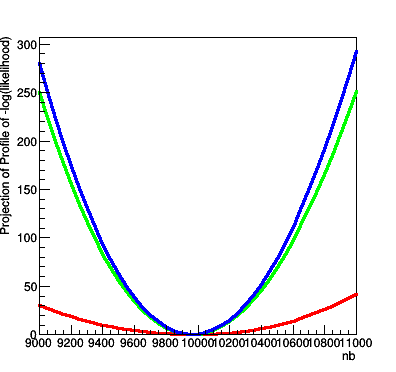

In [11]:
frame = rv_bkg.frame(ROOT.RooFit.Bins(20), ROOT.RooFit.Range(9000,11000))

#Plot the profile likelihood for nbkg
pll_b1 = nll.createProfile(ROOT.RooArgSet(rv_bkg))
pll_b1.plotOn(frame, ROOT.RooFit.LineColor(ROOT.kRed))

pll_b2 = nll2.createProfile(ROOT.RooArgSet(rv_bkg))
pll_b2.plotOn(frame, ROOT.RooFit.LineColor(ROOT.kGreen))

pll_b3 = nllsim.createProfile(ROOT.RooArgSet(rv_bkg) )
pll_b3.plotOn(frame, ROOT.RooFit.LineColor(ROOT.kBlue))

c=ROOT.TCanvas("c_p2","c_p2",400,400)
frame.Draw()
c.Draw()

### Part 3: Nuisances
Let's go back to the only SR fit. Add a polynomial modification to the shape, such as we get a linear modification of the background shape of 10% gaussian constraint.

Fitted number of events: S= 200.397684154 B= 9871.61280817 TOT= 10072.0104923
strength= 2.00698730108 TOT data= 10072.0

[#1] INFO:NumericIntegration -- RooRealIntegral::init([hp_bkg_X_shapeb]_Norm[x]_denominator_Int[x]) using numeric integrator RooIntegrator1D to calculate Int(x)
[#1] INFO:Minization --  Including the following contraint terms in minimization: (nuis)
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_model3_dh_data_with_constr) Summation contains a RooNLLVar, using its error level
 **********
 **   13 **MIGRAD        1500           1
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT, WITH IFLAG=4.
 START MIGRAD MINIMIZATION.  STRATEGY  1.  CONVERGENCE WHEN EDM .LT. 1.00e-03
 FCN=-59580.2 FROM MIGRAD    STATUS=INITIATE       12 CALLS          13 TOTAL
                     EDM= unknown      STRATEGY= 1      NO ERROR MATRIX       
  EXT PARAMETER               CURRENT GUESS       STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE 

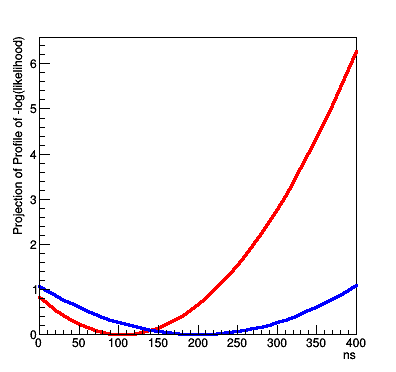

In [12]:
## trying to play with some uncertainty.

shape=ROOT.RooRealVar("shape","shape",-1,1)
pdfShape=ROOT.RooPolynomial("shapeb","shapeb",x,
                            ROOT.RooArgList( 
                                shape
                            ), 1)
modelb2=ROOT.RooProdPdf("model_b2","model_b2",ROOT.RooArgList(pdf[1],pdfShape) )

# shape is gaussian constrained with mean 0 and sigma 0.01
nuisPdf=ROOT.RooGaussian("nuis","nuis",shape,ROOT.RooFit.RooConst(0),ROOT.RooFit.RooConst(0.01))

model3_stat=ROOT.RooAddPdf("model3_stat","model_s",
                           ROOT.RooArgList(pdf[0],modelb2), 
                           ROOT.RooArgList(rv_sig,rv_bkg) 
                          ) 
model3_full=ROOT.RooProdPdf("model3","model3",ROOT.RooArgList(model3_stat,nuisPdf))

nll3=model3_full.createNLL(dh[0],ROOT.RooFit.Extended())
minuit3=ROOT.RooMinuit(nll3)
minuit3.migrad()
minuit3.improve()
minuit3.hesse()

print "Fitted number of events: S=",rv_sig.getVal(),"B=",rv_bkg.getVal(),"TOT=",rv_sig.getVal()+rv_bkg.getVal()
print "strength=",rv_sig.getVal()/h_sig.Integral(), "TOT data=",h_data.Integral()

frame = rv_sig.frame(ROOT.RooFit.Bins(20), ROOT.RooFit.Range(0,400))

#Plot the profile likelihood in nsig
pll_frac.plotOn(frame, ROOT.RooFit.LineColor(ROOT.kRed))

#plot the likelihood with nuisances
pll3 = nll3.createProfile(ROOT.RooArgSet(rv_sig) )
pll3.plotOn(frame, ROOT.RooFit.LineColor(ROOT.kBlue))

c=ROOT.TCanvas("c_pl","c_pl",400,400)
frame.Draw()
c.Draw()
